# Words are Hard!
### Exploration with DeepNLP for Ontological Word-Sense Disambiguation
### By Uthman Apatira

Consider the following sentence:

> _Alexis won the bet agaist her car._

Quite confusing even for a native English speaker, much less for a deterministic computer. First of all, who exactly is _her_ referring to here? In English, Alexis is a unisex name, so _her_ might very well be referring to Alexis herself or perhaps some other party. The usage of pronouns makes the sentence appear more natural, but also introduces **referential ambiguity**. The way we (people) normally overcome this is by discourse analysis, that is, by examining the immediately preceeding sentences.

Additionally, is the word _bet_ being used as a noun or as a verb? Humans readily identify it as being a noun in this case; but a computer making use of NLP techniques would only have a single feature (TF-IDF) or a single word embedding (Glove/Word2Vec) to describe _bet_ in any context used, noun, verb, or otherwise. This is called **lexical ambiguity**.

Finally, the sample sentence above also exhibits **syntactical ambiguity** because it is not clear if Alexis was betting against her own car, i.e. she assumed her car would not be able to fulfill the conditions of the bet, _or_ if Alexis was physically stationed next to her car.

Part of the beauty of language is its intrisic ambiguity. It's honestly a meracle we can communite and understand each other at all! This notebook will demonstrate some best practices and dive into a few modern NLP techniques that can help computer models perform better at natural language understanding. Stated formally, this notebook will cover some explaratory data analysis ad modeling with ontological word-sense disambiguation.

# Table Of Contents

- [Named Entity Tagging](#Named-Entity-Tagging)
- [Classical Sentiment Analysis](#Classical-Sentiment-Analysis)
- [Bayesian Hyperparameter Tuning](#Bayesian-Hyperparameter-Tuning)
- [Embedding Training](#Embedding-Training)
- [Sentiment Analysis with CNNs](#Sentiment-Analysis-with-CNNs)
- [Sentiment Analysis with RNNs](#Sentiment-Analysis-with-RNNs)
- [Sentiment Analysis with RNNs+CNNs](#Sentiment-Analysis-with-RNNs+CNNs)
- [POS-Augmentation for Embeddings](#POS-Augmentation-for-Embeddings)
- [Transfer Learning](#Transfer-Learning)
- [Reflections](#Reflections)

# Named Entity Tagging

Our journey starts with _Named Entity Tagging_, also known as named entity recognition. A named entity is just some entity that deserves to have a name =). The process of tagging them seeks to classify named entities into some pre-defined categories such as the names of persons, organizations, places, etc.

By properly tagging named entities, our desire is to have a strong ally in our battle of ontological word-sense disambiguation.

In [2]:
import sys, nltk
from nltk.chunk import tree2conlltags

In [3]:
# Downlod some nltk packages, if necessary
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /home/authman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/authman/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/authman/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/authman/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
sample_lines = [
    'Alexis won the bet agaist her car.',
    'Free us from the tyranny of technology, making a connected life a more human experience.',
    'He started working at Microsoft in Seattle, Washington.',
    'San Francisco has a IBM office.'
]

In [5]:
def NETagger(line):
    results = []
    
    # A potnetial improvment :
    # Some organizations, e.g. 'JC Penny', places 'San Francisco'
    # and name-nouns, 'Brian Kursar' are multi-word. We can 
    # combine them..

    # Tag the individual parts of speech;
    line = nltk.pos_tag(line)

    # Now, extract named entities via parse tree
    line = nltk.ne_chunk(line)

    # Finally, covert the tree to a list of
    # tag-tuples: (word, pos, tag)
    line = nltk.tree2conlltags(line)

    for word,pos,tag in line:
        if 'GPE' in tag:            tag = 'PLACE'
        elif 'ORGANIZATION' in tag: tag = 'ORGANIZATION'
        elif 'NN' in pos:           tag = 'NOUN'
        elif 'VB' in pos:           tag = 'VERB'
        else:                       tag = 'OTHER'
        results.append(tag)
        
    return results

In [6]:
#for line in sys.stdin:
for line in sample_lines:
    print('\x1b[1;31m' + line + '\x1b[0m')
    
    # Chop it up, we can use regex to do this directly
    line = nltk.word_tokenize(line)
    
    results = NETagger(line)
    for i,word in enumerate(line):
        if results[i] == 'OTHER': continue
        print(word, 'is', results[i])
    print('')

Alexis won the bet agaist her car.
Alexis is NOUN
won is VERB
bet is NOUN
agaist is NOUN
car is NOUN

Free us from the tyranny of technology, making a connected life a more human experience.
tyranny is NOUN
technology is NOUN
making is VERB
life is NOUN
experience is NOUN

He started working at Microsoft in Seattle, Washington.
started is VERB
working is VERB
Microsoft is ORGANIZATION
Seattle is PLACE
Washington is PLACE

San Francisco has a IBM office.
San is PLACE
Francisco is NOUN
has is VERB
IBM is ORGANIZATION
office is NOUN



Not bad! NLTK's `pos_tag` has support for many more parts of speech, and the `ne_chunk` chunker can identify many more named entities that what we've listed. By for this demo notebook, our dataset will be sufficiently small that if we get too crazy at this point, there potentially won't be enough overlap. That stated, to see the full tagset, execute the cell below. For our purposes, we're limiting the output to just nouns, verbs, places, and organizations. Everything else will just be marked as `'other'`:

In [7]:
# Let's see what it gives us...
# nltk.help.upenn_tagset()

# Classical Sentiment Analysis

Here by 'classical', I mean imploring the use of term-frequency, inverse-term-frequency. We will stack this transformer under either a logistic regression classifier for our final classification.

To get us started, I'll be using the `Large Movie Review Dataset`, which is a very balanced dataset of 25k positive and 25k negative reviews of different movies, with no more than 30 reviews per particular movie. So that I don't forget:

```
@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}
```

The dataset is quite messy, all the reviews are in separate files. Let's bunch them up into .feather files for easy loading.

In [8]:
import os, gc, re
import pandas as pd
import numpy as np
import pickle

# For the fancy jupyter status bar
from tqdm import *

In [9]:
train_neg = os.listdir("net/aclImdb/train/neg/")
train_pos = os.listdir("net/aclImdb/train/pos/")
test_neg = os.listdir("net/aclImdb/test/neg/")
test_pos = os.listdir("net/aclImdb/test/pos/")

len(train_pos), len(train_neg), len(test_pos), len(test_neg)

(12500, 12500, 12500, 12500)

In [10]:
train = []

for file in tqdm(train_neg):
    with open("net/aclImdb/train/neg/" + file) as fhandler:
        train.append([0, fhandler.read()])
        
for file in tqdm(train_pos):
    with open("net/aclImdb/train/pos/" + file) as fhandler:
        train.append([1, fhandler.read()])
        
train = pd.DataFrame(train, columns=['sentiment','comment'])


test = []
for file in tqdm(test_neg):
    with open("net/aclImdb/test/neg/" + file) as fhandler:
        test.append([0, fhandler.read()])
        
for file in tqdm(test_pos):
    with open("net/aclImdb/test/pos/" + file) as fhandler:
        test.append([1, fhandler.read()])
        
test  = pd.DataFrame(test, columns=['sentiment','comment'])

100%|██████████| 12500/12500 [00:02<00:00, 5866.81it/s]


In [11]:
# Stash as feather for easy future access
train.to_feather('net/train.ftr')
test.to_feather('net/test.ftr')

In [12]:
# This is how to load it in the future
train = pd.read_feather('net/train.ftr')
test  = pd.read_feather('net/test.ftr')

In [13]:
train.head()

,sentiment,comment
0,0,I read all the reviews here AFTER watching thi...
1,0,"This movie was not very entertaining, certainl..."
2,0,This movie is entertaining enough due to an ex...
3,0,"This self proclaimed ""very talented artist"" ha..."
4,0,had some lovely poetic bits but is really just...


In [14]:
test.tail()

,sentiment,comment
24995,1,I first saw this film by chance when I was vis...
24996,1,Much better than expected. Good family flick -...
24997,1,I am trying to find somewhere to purchase a DV...
24998,1,Despite the title and unlike some other storie...
24999,1,Delightful! It never pretends to be a masterpi...


In [15]:
# Let's start by training the tdidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tdidf = TfidfVectorizer(
    lowercase   = True,
    stop_words  = 'english',
    ngram_range = (1, 2),
    max_df      = 0.4,
    min_df      = 5,
    binary      = False, 
    smooth_idf  = True
)

# We'll train our vctorizer using both train+test
tdidf.fit(train.comment.append(test.comment))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [16]:
# If this dataset didn't already provide us a train/test split, we could have
# use KFold, and re-ran our model a few times over.
train_idf = tdidf.transform(train.comment)
test_idf  = tdidf.transform(test.comment)

In [17]:
# Now, train a LReg classifier over our IDF vector.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
                               
lreg = LogisticRegression(
    dual    = False,  # For large dsets, this can speed things up . . .
    C       = 5.125,  # Our main hyperprameter
    n_jobs  = 1
)

lreg.fit(train_idf, train.sentiment)
predict = lreg.predict(test_idf)

print('Accuracy:', accuracy_score(test.sentiment, predict))

Accuracy: 0.88708


# Bayesian Hyperparameter Tuning

With 88% Accuracy, our score wasn't that great. There are many ways we can improve it. We can add tri-grams to the idf vectorizer. We can also introduce character n-grams as well. No matter what we do, it is always a good idea to tune our hyperparameters using our hold-out set.

One technique for doing this is grid-search over our hyperparameter space. This seems to be going out of fashion because Bayesian optimization is all the craze these days, so let's go with that. The deep learner, a 'frequentists', believes a model's parameters are fixed and the data is random. A bayesian learner on the other hand, holds that the _data_ is fixed, but the parameters are random. If you think about it, this makes sense because when a model is trained, the data is fixed and isn't random anymore. I won't go into more detail than that here, but I'll say that there are packages that will take the conditional probabilities out of you :-). Let's use the hyperopt to explore a possible hyperparam space and find the best `C`, `max_df`, and `min_df` values to maximize our accuracy score:

In [18]:
from hyperopt import fmin, tpe, hp, Trials, space_eval

In [19]:
# First, define the search space:
space = {
    'ngram_range': hp.choice('x_ngram_range', [(1,1), (1,2), (1,3)]),
    'min_df'     : hp.quniform('x_min_df', 3, 6, 1),
    'max_df'     : hp.uniform('x_max_df', 0.4, 1.0),
    'C'          : hp.uniform('x_C', 0.1, 10),
}

In [20]:
# Then define our objective function
def objective(space):
    # This is where KFold would come into play. We actually have a small
    # DSet and using ALL of it (test+train) would be beneficial. We can
    # Concatenate both sets, then do KFold x-validation here. But for this
    # demo, we'll just use the test set as-is.
    global train, test
    
    # Debugging:
    print(space)
    
    tdidf = TfidfVectorizer(
        lowercase   = True,
        stop_words  = 'english',
        ngram_range = space['ngram_range'],
        max_df      = space['max_df'],
        min_df      = int(space['min_df']),
        binary      = False, 
        smooth_idf  = True
    )
    tdidf.fit(train.comment.append(test.comment))
    
    lreg = LogisticRegression(
        dual    = False,
        C       = space['C']
    )
    lreg.fit(train_idf, train.sentiment)
    
    predict = lreg.predict(test_idf)
    score   = accuracy_score(test.sentiment, predict)
    print('\t', score, '\n')
    
    # 1-score, since we're going to attempt to minimize this value
    return 1.0 - score

In [21]:
# The Trials object will store details of each iteration
trials = Trials()

# Run it:
best = fmin(
    objective,
    space     = space,
    algo      = tpe.suggest,
    max_evals = 10
)

# Get the values of the optimal parameters
best_params = space_eval(space, best)

{'C': 3.0606887543996963, 'max_df': 0.5618433074066356, 'min_df': 4.0, 'ngram_range': (1, 2)}
	 0.88624 

{'C': 9.346095270971665, 'max_df': 0.4811437711583409, 'min_df': 4.0, 'ngram_range': (1, 3)}
	 0.88496 

{'C': 8.86599382635101, 'max_df': 0.9835505665598256, 'min_df': 5.0, 'ngram_range': (1, 3)}
	 0.88512 

{'C': 2.531381705909005, 'max_df': 0.5198443883233169, 'min_df': 6.0, 'ngram_range': (1, 3)}
	 0.88576 

{'C': 6.930366842543968, 'max_df': 0.5525014488080969, 'min_df': 4.0, 'ngram_range': (1, 2)}
	 0.88604 

{'C': 4.189597138737334, 'max_df': 0.4453876676869535, 'min_df': 6.0, 'ngram_range': (1, 2)}
	 0.88708 

{'C': 3.407494420130505, 'max_df': 0.6123552378516658, 'min_df': 3.0, 'ngram_range': (1, 2)}
	 0.8866 

{'C': 7.030869445011589, 'max_df': 0.5526430492433034, 'min_df': 4.0, 'ngram_range': (1, 2)}
	 0.886 

{'C': 9.100614699103993, 'max_df': 0.4092647835386215, 'min_df': 4.0, 'ngram_range': (1, 1)}
	 0.88512 

{'C': 8.180403568445342, 'max_df': 0.8340350734358322, 'mi

Alright, it looks like the tuned-TfIDF gets us all the way up to **88.704% accuracy**.

# Embedding Training

Now that we've gotten as far as we believe we can with TFIDF, let's move on to neural networks.

We could feed in our sparse TF-IDF representation as input into our net (think one hot encoding). But instead, we're going to try to create an embedding, or lower level representation of our language data. This will involve us first tokenizing our textual corpus into indices, and then assigning a random, trainable weight vector to each word.

Before starting, we're going to need to set a fixed input size for our comments. How do we know what size to use? Let's see what the data tells us:

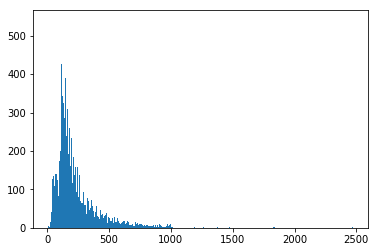

In [22]:
import matplotlib.pyplot as plt

words = train.comment.str.count('\S+').astype(np.uint16)

plt.hist(words, bins=1000)
plt.show()

**250** will be a very competitive number of words. It'll capture most of the next of most of our comments.

In [23]:
from random import shuffle

import keras.backend as K
from keras.preprocessing import text, sequence
from keras.layers import Input, SpatialDropout1D,Dropout, GlobalAveragePooling1D, CuDNNGRU, Bidirectional, Dense, Embedding, Conv1D 
from keras.models import Model
from keras.optimizers import Adam, Nadam
from keras.callbacks import ModelCheckpoint

from gensim.models import Word2Vec

from sklearn import metrics

import gc

In [24]:
max_vocab_size  = 100000   # We won't use more than 100K words
max_text_len    = 250      # We'll only examine up to the first 100 words of each review

embedding_dimension = 100    # Each word will be represented with a dense, 100 unit vector
embedding_maxvocab  = 500000 # Our language model will know up to 500k words, probably more than in our toy dset
embedding_cbow_win  = 5      # Window size for unsuperivsd text context learning

In [25]:
all_comments = train.comment.append(test.comment).values
all_comments = [text.text_to_word_sequence(comment) for comment in tqdm(all_comments)]

w2v = Word2Vec(size=embedding_dimension, window=embedding_cbow_win, max_vocab_size=embedding_maxvocab)
w2v.build_vocab(all_comments)
w2v.train(all_comments, total_examples=w2v.corpus_count, epochs=5)

w2v.save('net/embedding.w2v')

del all_comments; gc.collect()

100%|██████████| 50000/50000 [00:01<00:00, 29146.72it/s]


0

Note, we allow our embedding vocabulary to be quite big, but this is because while building the corpus, we don't know which words are important yet. Later on once we start supervised learning, we can prune accordingly.

Next up, let's build a mapper to tokenize our text (change the words -> vocab indices):

In [26]:
tokenizer = text.Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(
    list(train.comment.fillna('NA').values) + list(test.comment.fillna('NA').values)
)

In [27]:
def remove_stopwords(tokenizer):
    # Just like we did with TfIdf, let's remove stopwords
    # From our vocabulary
    
    C_MIN_WF = 4
    C_MIN_DF = 4
    C_MAX_DF = tokenizer.document_count * 0.4
    print('MAX_DF', C_MAX_DF)

    whack_words = [w for w,c in tokenizer.word_counts.items() if c < C_MIN_WF] + [w for w,c in tokenizer.word_docs.items() if c < C_MIN_DF or c > C_MAX_DF]
    whack_words = list(set(whack_words))
    for word in whack_words:
        del tokenizer.word_counts[word], tokenizer.word_index[word], tokenizer.word_docs[word]
        #tokenizer.num_words -= 1

    # Since we deleted some entris, relabel (fix) the word indices
    word_index_keys = tokenizer.word_index.keys()
    for i,word in enumerate(word_index_keys):
        tokenizer.word_index[word] = i+1
    print('Deleting', len(whack_words), 'words that appear too frequently or too infrequently')

    word_index_keys = tokenizer.word_index.keys()
    print(len(word_index_keys), 'words left')
    return tokenizer

In [28]:
tokenizer = remove_stopwords(tokenizer)

MAX_DF 20000.0
Deleting 79412 words that appear too frequently or too infrequently
44840 words left


In [29]:
# We just built the model, so no need to load it.
# But this is how that would be done:
w2v = Word2Vec.load('net/embedding.w2v')


# Start by initializing our embedding matrix [VocabSize x EmbeddingDimension]
word_index = tokenizer.word_index
nb_words   = min(max_vocab_size, len(word_index))
embedding_matrix = np.zeros((nb_words, embedding_dimension), dtype=np.float64)

# Since we're using a self trained embedding, our expectation is that there
# will be no out-of-vocabulary words present... but I'll leave that code in
# there anyway because I'll be coming back to it:
for word, i in word_index.items():
    if i >= max_vocab_size: continue
    try:
        embedding_vector = w2v.wv[word]
    except KeyError:
        embedding_vector = None
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [30]:
embedding_matrix.shape

(44840, 100)

In [31]:
# Now we can execute the tokenizer:
train_seq = tokenizer.texts_to_sequences(train.comment)
test_seq  = tokenizer.texts_to_sequences(test.comment)

# Add 0-padding to reach max_text_len size
train_seq = sequence.pad_sequences(train_seq, maxlen=max_text_len)
test_seq  = sequence.pad_sequences(test_seq,  maxlen=max_text_len)

In [32]:
print(train_seq.shape)

(25000, 250)


In [33]:
# The word "I" is mapped to this 100-unit vector:
train.comment[0][0], train_seq[0]

('I', array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
          298,   797,    92,    59,   106,   371,  1260,  1140,   509,
           27,   183,   189,  5196,   124,  1806,   288,   113,    60,
        11607,  2002,  4062,   251, 24346,  1151,  2208,   823,    58,
           38,   964,   172,   183,   111,   227,  5836,   161,   157,
           82,    66,  3763,    36,  2354,   229,   299,   262,  5758,
           25,   431,    34,   180,  8048,    85,  1362,    97,  5329,
         7019,  2929,  2009,    90,   290,   371,   798,  6015,  1467,
         1579,  2577,    17,    89,    35,   459, 15074,    12,    44,
         2988,  3750,  4869,   410,  5837,   187, 12269,   161,    20,
 

# Sentiment Analysis II with CNNs

That was a lot of prep work, but now we're ready to build a NNet model to perform sentiment analysis. For the loss function, I'll use binary log loss.

In [34]:
def simple_cnn_model(embedding_matrix):
    
    inp = Input(shape = (max_text_len, ))
    x = Embedding(
        nb_words,
        embedding_dimension,
        weights      = [embedding_matrix],
        input_length = max_text_len,
        trainable    = False
    )(inp)
    
    x = SpatialDropout1D(0.2)(x)
    x = Conv1D(filters=32, kernel_size=3, activation = 'relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x) # Squash
    
    model = Model(inputs=inp, outputs=x)

    model.compile(
        optimizer = Nadam(lr=0.01, clipvalue=0.5),
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = simple_cnn_model(embedding_matrix)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          4484000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 248, 32)           9632      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total para

This is a very simple model. Notice that our embedding layer is now frozen. Our understanding is that the embedding layer encoders some information about 'English', which includes syntax, semantics, and pragmatics to some degree. We don't want to change that. Rather, we'll leave it to our convolutional filters to learn the target mapping of good / bad sentiment.

In [35]:
check_point = ModelCheckpoint(
    'net/best_cnn_model.hdf5',
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    verbose = 1
)

model.fit(
    train_seq, train.sentiment,
    batch_size = 16,
    epochs     = 10,
    verbose    = 1,
    callbacks  = [check_point],
    validation_data = (test_seq, test.sentiment)
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
24544/25000 [============================>.] - ETA: 0s - loss: 0.4466 - acc: 0.8047
Epoch 00001: val_loss improved from inf to 0.37713, saving model to net/best_cnn_model.hdf5
25000/25000 [==============================] - 5s 196us/step - loss: 0.4475 - acc: 0.8038 - val_loss: 0.3771 - val_acc: 0.8485
Epoch 2/10
24608/25000 [============================>.] - ETA: 0s - loss: 0.4099 - acc: 0.8225
Epoch 00002: val_loss improved from 0.37713 to 0.34884, saving model to net/best_cnn_model.hdf5
25000/25000 [==============================] - 4s 148us/step - loss: 0.4099 - acc: 0.8227 - val_loss: 0.3488 - val_acc: 0.8600
Epoch 3/10
24592/25000 [============================>.] - ETA: 0s - loss: 0.3929 - acc: 0.8321
Epoch 00003: val_loss improved from 0.34884 to 0.33718, saving model to net/best_cnn_model.hdf5
25000/25000 [==============================] - 4s 149us/step - loss: 0.3930 - acc: 0.8324 - val_loss: 0.3372 - val_acc: 0.8644


At **87.44%**, our convlutional model performed _sliiiiightly_ worse than our classical IDF-LReg model (which had **88.704%** accuracy), how disappointing. Some things to note -- we used `kernel_size=3`, and don't have any spatial pooling (only temporal pooling). You can imagine here we're looking at n=3 grams ONLY. Our TFIDF model used n=1,2, and 3 gram combinations. We could adjust our nnet with additional kernels to consider additional n-grams as well, but that won't be explored in this notebook. There are many other ways to improve our network as well, the least of which being tuning the model's hyperparams, but let's take a look at an RNN model:

# Sentiment Analysis II with RNNs

In [40]:
def simple_rnn_model(embedding_matrix):
    
    inp = Input(shape = (max_text_len, ))
    x = Embedding(
        nb_words,
        embedding_dimension,
        weights      = [embedding_matrix],
        input_length = max_text_len,
        trainable    = False
    )(inp)
    
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(CuDNNGRU(16, return_sequences=True))(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x) # Squash
    
    model = Model(inputs=inp, outputs=x)

    model.compile(
        optimizer = Nadam(lr=0.01, clipvalue=0.5),
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = simple_rnn_model(embedding_matrix)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 250, 100)          4484000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 250, 100)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 250, 32)           11328     
_________________________________________________________________
global_average_pooling1d_4 ( (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total para

In [41]:
check_point = ModelCheckpoint(
    'net/best_rnn_model.hdf5',
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    verbose = 1
)

model.fit(
    train_seq, train.sentiment,
    batch_size = 16,
    epochs     = 5,
    verbose    = 1,
    callbacks  = [check_point],
    validation_data = (test_seq, test.sentiment)
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
24992/25000 [============================>.] - ETA: 0s - loss: 0.4161 - acc: 0.8191
Epoch 00001: val_loss improved from inf to 0.34518, saving model to net/best_rnn_model.hdf5
25000/25000 [==============================] - 40s 2ms/step - loss: 0.4163 - acc: 0.8190 - val_loss: 0.3452 - val_acc: 0.8545
Epoch 2/5
24944/25000 [============================>.] - ETA: 0s - loss: 0.3807 - acc: 0.8373
Epoch 00002: val_loss improved from 0.34518 to 0.33746, saving model to net/best_rnn_model.hdf5
25000/25000 [==============================] - 40s 2ms/step - loss: 0.3811 - acc: 0.8372 - val_loss: 0.3375 - val_acc: 0.8602
Epoch 3/5
24960/25000 [============================>.] - ETA: 0s - loss: 0.3724 - acc: 0.8413
Epoch 00003: val_loss improved from 0.33746 to 0.33238, saving model to net/best_rnn_model.hdf5
25000/25000 [==============================] - 39s 2ms/step - loss: 0.3724 - acc: 0.8413 - val_loss: 0.3324 - val_acc: 0.8606
Epoch 

Since at train and test time, we have the entire sentence available, it makes sense that we use a bidirectional rnn rather than just limiting ourselves to processing the sentence unidirectionally. I've decided to use 16-processing units per direction, just so we can match the total '32' neuron count in our convolutional network. These figures are pulld out of the air, lol.

But take a look at that training time. RNNs are a LOTT slower than CNNs because they consume the data recursively. There is some research out there on [helping RNNs perform better in parallel](NLP QRNN: https://arxiv.org/pdf/1803.08240.pdf), but it's is not widely adopted as of yet. We can use a larger batch size to speed things up, but that affects training quality.

Using RNNs, we were able to acheive an accuracy of **86.18%** on the sentiment analysis task.

# Sentiment Analysis II with RNNs+CNNs

For complteness, let's see what happens when we combine both RNN and CNN processing. I'm going to bump up the dropout amount a bit to bolster regularization. Perhaps some L2 could be useful as well...

In [42]:
def simple_rcnn_model(embedding_matrix):
    
    inp = Input(shape = (max_text_len, ))
    x = Embedding(
        nb_words,
        embedding_dimension,
        weights      = [embedding_matrix],
        input_length = max_text_len,
        trainable    = False
    )(inp)
    
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(CuDNNGRU(16, return_sequences=True))(x)
    x = Conv1D(filters=32, kernel_size=1, activation = 'relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid')(x) # Squash
    
    model = Model(inputs=inp, outputs=x)

    model.compile(
        optimizer = Nadam(lr=0.01, clipvalue=0.5),
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = simple_rnn_model(embedding_matrix)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 250)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 250, 100)          4484000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 250, 100)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 250, 32)           11328     
_________________________________________________________________
global_average_pooling1d_5 ( (None, 32)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total para

In [43]:
check_point = ModelCheckpoint(
    'net/best_rcnn_model.hdf5',
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    verbose = 1
)

model.fit(
    train_seq, train.sentiment,
    batch_size = 16,
    epochs     = 5,
    verbose    = 1,
    callbacks  = [check_point],
    validation_data = (test_seq, test.sentiment)
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
24976/25000 [============================>.] - ETA: 0s - loss: 0.4180 - acc: 0.8156
Epoch 00001: val_loss improved from inf to 0.33774, saving model to net/best_rcnn_model.hdf5
25000/25000 [==============================] - 40s 2ms/step - loss: 0.4181 - acc: 0.8156 - val_loss: 0.3377 - val_acc: 0.8582
Epoch 2/5
24992/25000 [============================>.] - ETA: 0s - loss: 0.3794 - acc: 0.8384
Epoch 00002: val_loss did not improve
25000/25000 [==============================] - 39s 2ms/step - loss: 0.3793 - acc: 0.8384 - val_loss: 0.3438 - val_acc: 0.8553
Epoch 3/5
24992/25000 [============================>.] - ETA: 0s - loss: 0.3743 - acc: 0.8421
Epoch 00003: val_loss improved from 0.33774 to 0.33717, saving model to net/best_rcnn_model.hdf5
25000/25000 [==============================] - 40s 2ms/step - loss: 0.3743 - acc: 0.8421 - val_loss: 0.3372 - val_acc: 0.8600
Epoch 4/5
24960/25000 [============================>.] - ETA: 

# POS-Augmentation for Embeddings

Okay, perhaps we can further improve our NNet scores by adding in either named entities or the part of speech information we worked on earlier? There are a few techniques we could use. One would be to train an embedding on our original text corpus converted into POS or NETs. Then, armed with an embedding to describe each distinct POS, we could simply concatenate that onto our input. Another methods would be to OHE the tags and just feed them in as a separate input vector. Let's try out the first method.

But first, a quick "Gotcha!":

In [44]:
nltk.word_tokenize("He started working at Microsoft in Seattle, Washington.")

['He',
 'started',
 'working',
 'at',
 'Microsoft',
 'in',
 'Seattle',
 ',',
 'Washington',
 '.']

In [45]:
text.text_to_word_sequence("He started working at Microsoft in Seattle, Washington.")

['he', 'started', 'working', 'at', 'microsoft', 'in', 'seattle', 'washington']

Notice that Keras's text tokenizer converts everything to lowercase? That will mess up our NET. So let's use nltk's tokenizer this round instead:

In [46]:
netag_max_vocab_size       = 6   # place, org, noun, verb, other (0 is empty)
netag_embedding_dimension  = 3   # Meh, should do it. min(50, dimen//2)

This process takes a while, so let's use all our (my) available CPU threads to speed it up:

In [47]:
from multiprocessing import Pool

def build_ne_tags():
    global train, test
    
    NUM_THREADS = 12

    all_ne_tags = train.comment.append(test.comment).values
    with Pool(NUM_THREADS) as pool:  all_ne_tags = pool.map(nltk.word_tokenize, all_ne_tags)
    with Pool(NUM_THREADS) as pool:  all_ne_tags = pool.map(NETagger, all_ne_tags)
        
    return all_ne_tags

In [48]:
# Now we're in business :-)
all_ne_tags = build_ne_tags()

In [49]:
w2v_tag = Word2Vec(size=netag_embedding_dimension, window=embedding_cbow_win, max_vocab_size=netag_max_vocab_size)
w2v_tag.build_vocab(all_ne_tags)
w2v_tag.train(all_ne_tags, total_examples=w2v.corpus_count, epochs=5)

# Store resulting embedding
w2v_tag.save('net/net_embedding.w2v')

In [50]:
# In case we're coming in from another run where we have it saved already:
w2v_tag = Word2Vec.load('net/net_embedding.w2v')

# Stash the data back into our dset
train['netags'] = all_ne_tags[:train.shape[0]]
test['netags']  = all_ne_tags[train.shape[0]:]

In [51]:
train.head()

,sentiment,comment,netags
0,0,I read all the reviews here AFTER watching thi...,"[OTHER, VERB, OTHER, OTHER, NOUN, OTHER, VERB,..."
1,0,"This movie was not very entertaining, certainl...","[OTHER, NOUN, VERB, OTHER, OTHER, OTHER, OTHER..."
2,0,This movie is entertaining enough due to an ex...,"[OTHER, NOUN, VERB, VERB, OTHER, OTHER, OTHER,..."
3,0,"This self proclaimed ""very talented artist"" ha...","[OTHER, NOUN, VERB, OTHER, OTHER, OTHER, NOUN,..."
4,0,had some lovely poetic bits but is really just...,"[VERB, OTHER, OTHER, OTHER, NOUN, OTHER, VERB,..."


Next, rebuild the CNN model to take dual inputs:

In [52]:
w2v_tag.wv.vocab

{'NOUN': <gensim.models.keyedvectors.Vocab at 0x7f3303da4438>,
 'ORGANIZATION': <gensim.models.keyedvectors.Vocab at 0x7f3303da4400>,
 'OTHER': <gensim.models.keyedvectors.Vocab at 0x7f3303dc4f60>,
 'PLACE': <gensim.models.keyedvectors.Vocab at 0x7f3303da4390>,
 'VERB': <gensim.models.keyedvectors.Vocab at 0x7f3303dc4e10>}

In [53]:
tagger = {
    'oov':          0,
    'NOUN':         1,
    'ORGANIZATION': 2,
    'OTHER':        3,
    'PLACE':        4,
    'VERB':         5,
}

In [54]:
# Start by initializing our embedding matrix [VocabSize x EmbeddingDimension]
net_embedding_matrix = np.zeros((netag_max_vocab_size, netag_embedding_dimension))

# Self trained, no OOV:
for key,val in tagger.items():
    try:
        net_embedding_matrix[val] = w2v_tag.wv[key]
    except KeyError:
        pass

In [55]:
# Cool !
net_embedding_matrix

array([[ 0.        ,  0.        ,  0.        ],
       [-0.41369095, -0.35485178,  0.25164878],
       [-0.92024428, -0.79106778, -7.99419308],
       [ 0.16811559, -0.58408523,  0.74580336],
       [-6.41222095,  1.95210791, -2.73351336],
       [ 0.47213939, -0.67386639,  1.17783999]])

In [56]:
train_seq_net = train.netags.map(lambda tags: [tagger[tag] for tag in tags])
test_seq_net  = test.netags.map(lambda tags: [tagger[tag] for tag in tags])

# Add 0-padding to reach max_text_len size
train_seq_net = sequence.pad_sequences(train_seq_net, maxlen=max_text_len)
test_seq_net  = sequence.pad_sequences(test_seq_net,  maxlen=max_text_len)

In [59]:
# Setup our dual-head CNN:
from keras.layers.merge import concatenate

def intermediate_cnn_model(embedding_matrix, net_embedding_matrix):
    
    inp  = Input(shape = (max_text_len, ))
    inp2 = Input(shape = (max_text_len, ))
    
    x = Embedding(
        nb_words,
        embedding_dimension,
        weights      = [embedding_matrix],
        input_length = max_text_len,
        trainable    = False
    )(inp)
    
    y = Embedding(
        netag_max_vocab_size,
        netag_embedding_dimension,
        weights      = [net_embedding_matrix],
        input_length = max_text_len,
        trainable    = False
    )(inp2)
    
    x = SpatialDropout1D(0.2)(x)
    x = concatenate([
        # Text + NETags
        x, y
    ])
    
    x = Conv1D(filters=33, kernel_size=3, activation = 'relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x) # Squash
    
    model = Model(inputs=[inp,inp2], outputs=x)

    model.compile(
        optimizer = Nadam(lr=0.01, clipvalue=0.5),
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = intermediate_cnn_model(embedding_matrix, net_embedding_matrix)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 250, 100)     4484000     input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
spatial_dropout1d_7 (SpatialDro (None, 250, 100)     0           embedding_8[0][0]                
__________________________________________________________________________________________________
embedding_

In [60]:
check_point = ModelCheckpoint(
    'net/best_intermediate_cnn_model.hdf5',
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    verbose = 1
)

model.fit(
    [train_seq, train_seq_net], train.sentiment,
    batch_size = 16,
    epochs     = 10,
    verbose    = 1,
    callbacks  = [check_point],
    validation_data = ([test_seq, test_seq_net], test.sentiment)
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
24768/25000 [============================>.] - ETA: 0s - loss: 0.4460 - acc: 0.8022
Epoch 00001: val_loss improved from inf to 0.35944, saving model to net/best_intermediate_cnn_model.hdf5
25000/25000 [==============================] - 5s 183us/step - loss: 0.4462 - acc: 0.8020 - val_loss: 0.3594 - val_acc: 0.8535
Epoch 2/10
24928/25000 [============================>.] - ETA: 0s - loss: 0.4115 - acc: 0.8227
Epoch 00002: val_loss improved from 0.35944 to 0.34107, saving model to net/best_intermediate_cnn_model.hdf5
25000/25000 [==============================] - 4s 160us/step - loss: 0.4112 - acc: 0.8227 - val_loss: 0.3411 - val_acc: 0.8640
Epoch 3/10
24944/25000 [============================>.] - ETA: 0s - loss: 0.4006 - acc: 0.8300
Epoch 00003: val_loss improved from 0.34107 to 0.33948, saving model to net/best_intermediate_cnn_model.hdf5
25000/25000 [==============================] - 4s 158us/step - loss: 0.4004 - acc: 0.830

That's what I'm talking about. We were able to get a higher accuracy than our base CNN model, **87.75% vs 87.44%**. Stated differently, it looks like our net is better able to understand the subtleties of the English language now, even though we only add just 3 units to the net.

# Transfer Learning

Up until know, our results have been lackluster. Even adding in POS information, our Net has yet to eclipse the the **88.704%** results we got from TFiDF, though they came pretty close.

This shouldn't come as a surprise.

What we're essentially doing here is asking our model to not only analyze the sentiment of the movie reviews, but also derive some understanding of English. Recall that our neural nets have no context. They start not knowing _anything_, like babies, and then have to adapt to the world/problem around them. What would our accuracy look like if we first trained our embeddings against a much larger textual corpus than 50k movie reviews? What if we trained it on... Wikipedia?

For this task, I'll make use of 300-dimensional pre-trained [FastText](https://github.com/facebookresearch/fastText). This corpus is trained on the entire Wikipedia circa 2014, which consists of 6Billion tokens, 400K vocabulary words. I hope it performs even better :-).

In [61]:
embedding_dimension = 300

In [62]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
ftext = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open('net/wiki.en.vec'))

In [63]:
oov = []
word_index = tokenizer.word_index
nb_words   = min(max_vocab_size, len(word_index))

# Any OOV word, will have a 0-vector
embedding_matrix = np.zeros((nb_words, embedding_dimension))

for word, i in word_index.items():
    if i >= max_vocab_size or i>=nb_words: break
    vec = ftext.get(word)
    if vec is None:
        oov.append(word)
    else:
        embedding_matrix[i] = vec
        
print(len(oov), 'OOV tokens')

4426 OOV tokens


In [64]:
oov[:20]

["it's",
 "don't",
 "i'm",
 "doesn't",
 "didn't",
 '10',
 "can't",
 "that's",
 "i've",
 "isn't",
 "there's",
 '2',
 "he's",
 "wasn't",
 '1',
 "you're",
 '3',
 "couldn't",
 '5',
 '4']

After getting rid of stopwords, which are of little benefit because they are used too often and don't have discriminating power or are used too infrequently and thus won't generalize, we're left with a much smaller vocabulary set with only 4426 OOF tokens. Clearly, we need to do some pre-processing work, such as splitting on "'"'s and perhaps mapping numbers from "10" -> "ten", "9" -> "nine, etc. Maybe next time, since this notebook is getting quite long ...

Let's rebuild our first (simple) CNN model, with the only change being the embedding matrix:

In [65]:
model = simple_cnn_model(embedding_matrix)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 250)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 250, 300)          13452000  
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 250, 300)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 248, 32)           28832     
_________________________________________________________________
global_average_pooling1d_8 ( (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total para

In [66]:
check_point = ModelCheckpoint(
    'net/best_cnn_fasttext_model.hdf5',
    monitor = "val_loss",
    mode    = "min",
    save_best_only = True,
    verbose = 1
)

model.fit(
    train_seq, train.sentiment,
    batch_size = 16,
    epochs     = 5,
    verbose    = 1,
    callbacks  = [check_point],
    validation_data = (test_seq, test.sentiment)
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
24816/25000 [============================>.] - ETA: 0s - loss: 0.4771 - acc: 0.7810
Epoch 00001: val_loss improved from inf to 0.35198, saving model to net/best_cnn_fasttext_model.hdf5
25000/25000 [==============================] - 8s 330us/step - loss: 0.4763 - acc: 0.7812 - val_loss: 0.3520 - val_acc: 0.8559
Epoch 2/5
24816/25000 [============================>.] - ETA: 0s - loss: 0.3868 - acc: 0.8370
Epoch 00002: val_loss improved from 0.35198 to 0.33387, saving model to net/best_cnn_fasttext_model.hdf5
25000/25000 [==============================] - 6s 225us/step - loss: 0.3868 - acc: 0.8371 - val_loss: 0.3339 - val_acc: 0.8623
Epoch 3/5
24960/25000 [============================>.] - ETA: 0s - loss: 0.3600 - acc: 0.8528
Epoch 00003: val_loss improved from 0.33387 to 0.32823, saving model to net/best_cnn_fasttext_model.hdf5
25000/25000 [==============================] - 6s 232us/step - loss: 0.3598 - acc: 0.8528 - val_loss: 0

The Net trained with proper embeddings gave better results than the cold-start net, but not better results than the cold-start + NETagger net. You can probably guess the next best idea is to run training on all of Wikipedia, but this time taking into account NETags. Unfortunately, I'm not willing to donate my GPU time for that at this juuncture, but rest assured, the performance will beat TfIDF considerably.

# Reflections

There are quite a few observations to be made here. First, it's important to have a good understanding of one's problem. The objective here was sentiment analysis. For problems like this, usually, a few words: "I hated", "I loved", "very displeased", "dissapointed", "best movie", "unfortunately", "won't watch", "don't recommend", "brilliant film", etc. are sufficient to identify the sentiment of a comment. Knowing this might help design better model architectures to make the problem space easier to understand.

Furthermore, while a chainsaw cuts well, perhaps it's not the _best_ tool to wield while dining :-). Deep learning models perform the best when given a lot of data, but can underpreform vs classical machine learning on smaller datasets, if transfer learning isn't a possibility. At the end of the day, one should start with intuition, but it shoudn't end there. Try everything under the sun.

Also, neural nets are non-deterministic if not seeded. Re-running the net with different starting values could result in different accuracy / loss scores. Furthermore, we ran bayesian optimization on tf-idf/lreg but did not do so for our net. Optimizing our layer sizes, learning rate, batch rate, etc. will all have an effect on training.

That's all for now.